In [1]:
import itertools
import math
import time 
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils import spectral_norm
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch import autograd
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import gc
import glob
from tqdm.auto import tqdm
import os
import torch.nn.functional as F
import random as rand
from PIL import Image
import cv2 as cv
from datetime import datetime
#from torchsummary import summary

In [16]:
path = os.getcwd()
path

'C:\\Users\\great\\PycharmProjects\\reid'

In [17]:
files = glob.glob(path + '\\archive\\Market-1501-v15.09.15\\bounding_box_train\\*.jpg')
len(files)

12936

In [18]:
img = cv.imread(files[100])
img.shape

(128, 64, 3)

In [92]:
IMG_SIZE = 64

transforms1 = transforms.Compose(
    [
        
        #transforms.CenterCrop(380),
        transforms.Resize((64, 32)),
        #transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #transforms.Grayscale(num_output_channels=1)
    ]
)


class PersonsDataset(Dataset):

    def __init__(self, df, transforms=None):
        super().__init__()
        self.df_data = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_path = self.df_data[index]
        k = rand.randint(0,10)
        if k % 2 == 0:
            t = rand.randint(1,2)
        else:
            t = rand.randint(1,len(files)-1)
        img_path1 = self.df_data[(index+t)%len(files)]
        label = int(img_path[85:89])
        label1 = int(img_path1[85:89])
        img =   Image.open(img_path).convert("RGB")
        img1 =   Image.open(img_path1).convert("RGB")
        #print(img_path)
        #img = np.array(img, dtype=float)
        if self.transforms is not None:
            img = self.transforms(img)
            img1 = self.transforms(img1)
        #img = img.resize((60,60))
        return np.concatenate((np.array(img),np.array(img1))), float(label == label1)

In [93]:
ds = PersonsDataset(files, transforms1)
batch_size = 8
#for i in range(64,128):
#    print(ds[i][0].shape, ds[i][1])

In [94]:
trainloader = torch.utils.data.DataLoader(dataset=ds,
                                     batch_size=8,
                                     #pin_memory=True,
                                     shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


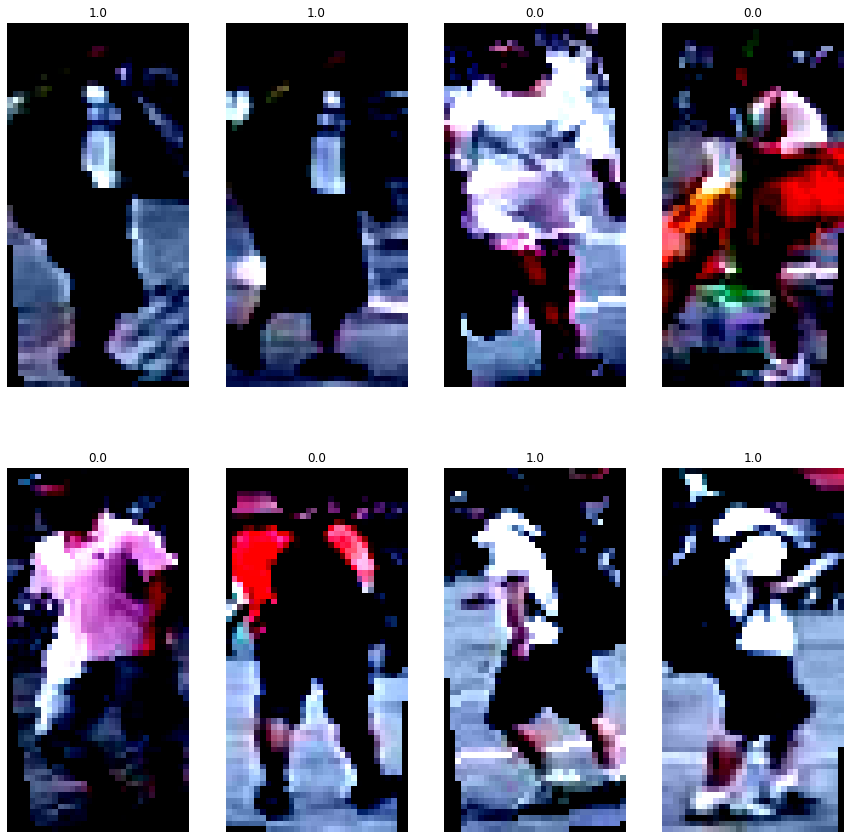

In [95]:
plt.figure(figsize=(15,15))
for i in range(0,8,2):
    ind = rand.randint(0,len(ds))
    plt.subplot(2, 4, 1 + i)
    sample = ds[ind]
    img = np.array((sample[0][0:3]*255), dtype=int)
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)
    plt.title(sample[1])
    plt.axis('off')  
    plt.imshow(img)
    plt.subplot(2, 4, 2 + i)
    img = np.array((sample[0][3:]*255), dtype=int)
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)
    plt.title(sample[1])
    plt.axis('off')  
    plt.imshow(img)
plt.show()

In [127]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        #self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(64 * 14 * 6, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        #x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()

In [133]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 15)

In [134]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc = 0.0
    with tqdm(total=len(ds)//8, position=0, desc=f'Epoch [{epoch + 1}/{20}]', unit='batch') as pbar:
        for i, data in enumerate(trainloader):
            inputs, labels = data
            #print(data[1])
            inputs = inputs.cuda()

            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = net(inputs)
            #print(outputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            outputs = torch.sigmoid(outputs) > 0.9
            train_acc =  np.sum(outputs.cpu().detach().numpy() == labels.unsqueeze(1).cpu().detach().numpy())/8*100
            running_acc += train_acc
            #scheduler.step(loss.item())
            # print statistics
            running_loss += loss.item()
            
            pbar.set_postfix(**{'loss': running_loss / (i+1), 'acc': running_acc / (i+1)})
            pbar.update(1)

Epoch [1/20]:   0%|          | 0/1617 [00:00<?, ?batch/s]

Epoch [2/20]:   0%|          | 0/1617 [00:00<?, ?batch/s]

Epoch [3/20]:   0%|          | 0/1617 [00:00<?, ?batch/s]

Epoch [4/20]:   0%|          | 0/1617 [00:00<?, ?batch/s]

Epoch [5/20]:   0%|          | 0/1617 [00:00<?, ?batch/s]

Epoch [6/20]:   0%|          | 0/1617 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [135]:
torch.save(net.state_dict(), 'id_009')

In [89]:
128*12*12

18432